In [1]:
%matplotlib inline

import katdal
import matplotlib
import os, string
import numpy, pylab
from scipy import integrate

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python2.7/dist-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The matplotlib.delaunay module was deprecated in version 1.4. Use matplotlib.tri.Triangulation instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Analysis input variables

In [2]:
# Observation file
filename   ='/var/kat/archive/data/MeerKATAR1/telescope_products/2016/03/17/1458202426.h5'
max_extent =5.         # deg
nsteps     =20.

# Antenna constants
ant ='m034'
pol ='V'

# Observation test parameters
delta         =max_extent/nsteps
target_offset =numpy.arange(max_extent,0-delta,-delta)

In [3]:
# Boltzman constant
k = 1.38e-23

# L-band receptors
receptor_serial={
'm062':{'band':'l', 'serial':4001},
'm063':{'band':'l', 'serial':4002},
'm031':{'band':'l', 'serial':4005},
'm034':{'band':'l', 'serial':4010},
'm024':{'band':'l', 'serial':4},
'm025':{'band':'l', 'serial':4003}}

# GPS satellite (SatelliteCalculator.xls)
GPSL1     = 1575.42e6    # Hz
GPSL2     = 1227.6e6     # Hz
dfnull    = 10.23e6      # Hz
dfpeak    = 3.*dfnull/2. # Hz
nullidx   = 8
fc     = GPSL2
fnull  = (fc-nullidx*dfnull)  # Hz

# GSM signal
fcGSM    = 941.2e6      # Hz
fcGSM1   = 953.2e6      # Hz

# Filtered passband frequencies
f_start = 900e6        # Hz
f_stop  = 1670e6       # Hz

# Noise diode models from EMSS calculation
noisefile = '/var/kat/katconfig/user/noise-diode-models/mkat/rx.l.%s.%s.csv'%(receptor_serial[ant]['serial'],string.lower(pol))

Read input file

In [4]:
try:
    h5 = katdal.open(filename, quicklook=True)
except Exception as err_msg: raise SystemExit('An error has occured:\n%s' % err_msg)
h5.select(reset='T')
h5.select(ants=ant,pol=pol,corrprods='auto',scans='track')
visibilities = h5.vis[:]
scan_indices = h5.scan_indices
passband = h5.channel_freqs
B_ch = (h5.spectral_windows[0]).channel_width
nr_dumps = []
for idx in scan_indices:
    h5.select(reset='T')
    h5.select(ants=ant,pol=pol,corrprods='auto',scans=idx)
    nr_dumps.append(h5.shape[0])
    
# Channel indices for passband baseline
min_idx=numpy.argmin(numpy.abs(passband-f_start))
max_idx=numpy.argmin(numpy.abs(passband-f_stop))
baseline_idx = range(min_idx, max_idx)
print "Channel range %d to %d" % (min_idx, max_idx)
print "Frequency range %f MHz to %f MHz" % (passband[min_idx]/1e6, passband[max_idx]/1e6)
# Extract passband only
visibilities = visibilities[:,baseline_idx,:]
passband = passband[baseline_idx]
# channel indices over target -- range of 40 MHz
dft=20e6
min_idx = numpy.argmin(numpy.abs(passband-(fc-dft/2.)))  # channel indices over target
max_idx = numpy.argmin(numpy.abs(passband-(fc+dft/2.)))
target_range = range(min_idx, max_idx)
# channel indices for null -- range of 10 MHz
dfn=10e6
min_idx = numpy.argmin(numpy.abs(passband-(fnull-dfn/2)))  # channel indices for null
max_idx = numpy.argmin(numpy.abs(passband-(fnull+dfn/2)))
null_range = range(min_idx, max_idx)

Channel range 211 to 3895
Frequency range 900.095703 MHz to 1669.994141 MHz


Show pointing with noise diode fires

/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


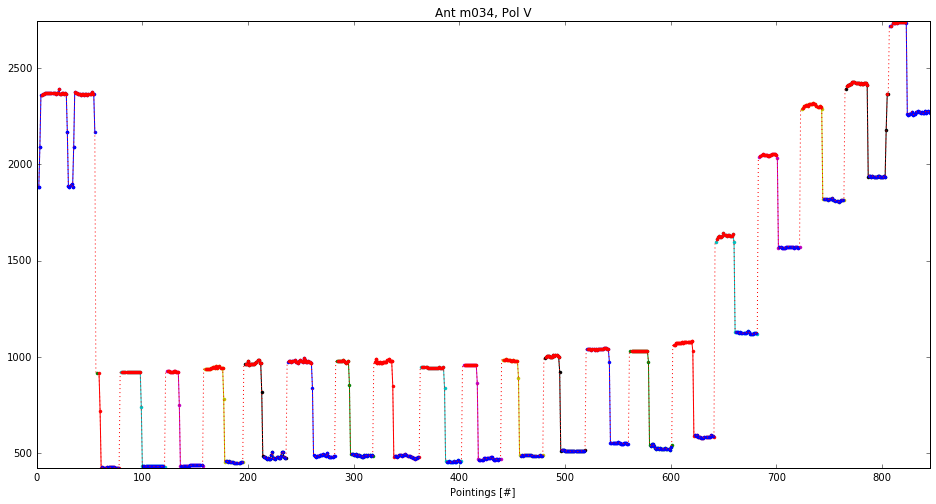

In [5]:
track_means = numpy.mean(numpy.abs(visibilities), axis=1)
pointings = numpy.arange(numpy.sum(nr_dumps))
pylab.figure(None,figsize = (16,8))
pylab.hold(True)
cntr=0
S_on = []
S_off = []
for idx in range(len(nr_dumps)):
    nr = nr_dumps[idx]
    threshold = numpy.average(track_means[cntr+1:cntr+nr])
    # everything above the threshold = with noise diode
    src_nd_idx = numpy.nonzero(track_means[cntr+1:cntr+nr] > threshold)[0][1:-1]
    S_on.append(numpy.mean(track_means[cntr+1:cntr+nr][src_nd_idx]))
    # everything below the threshold = without noise diode
    src_idx = numpy.nonzero(track_means[cntr+1:cntr+nr] < threshold)[0][1:-1]
    S_off.append(numpy.mean(track_means[cntr+1:cntr+nr][src_idx]))
    pylab.plot(pointings[cntr+1:cntr+nr], track_means[cntr+1:cntr+nr], '.-')
    pylab.plot(pointings[cntr+1:cntr+nr][src_nd_idx], track_means[cntr+1:cntr+nr][src_nd_idx], 'r.')
    pylab.plot(pointings[cntr+1:cntr+nr][src_idx], track_means[cntr+1:cntr+nr][src_idx], 'b.')
    cntr += nr
pylab.plot(pointings[:], track_means[:], 'r:')
pylab.hold(False)
pylab.title('Ant %s, Pol %s' % (ant, pol))
pylab.axis('tight')
pylab.xlabel('Pointings [#]')

Noise diode shows compression at 4.50 deg off target


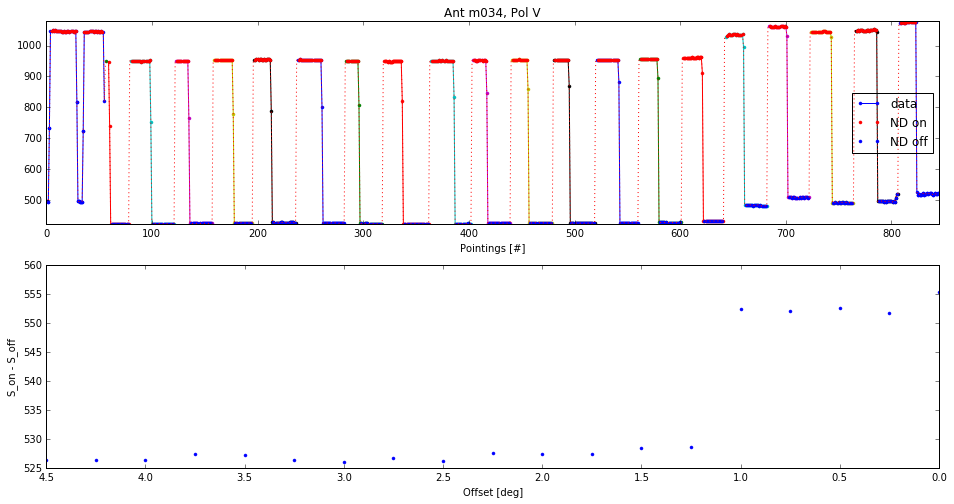

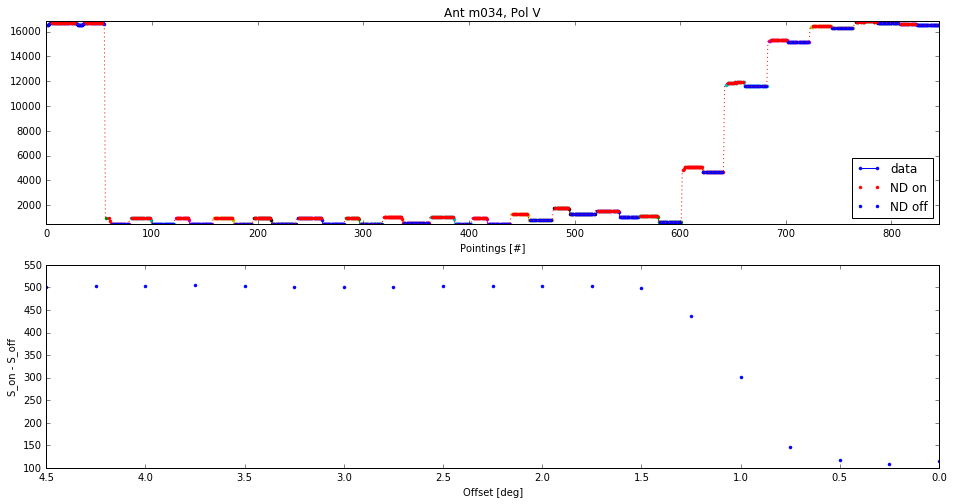

In [6]:
def noise_diode(mean_vis, pointings, nr_dumps, limits=False):
    inf_val = None
    pylab.figure(None,figsize = (16,8))
    pylab.subplot(211)
    pylab.hold(True)
    cntr=0
    S_on = []
    S_off = []
    for idx in range(len(nr_dumps)):
        nr = nr_dumps[idx]
        threshold = numpy.average(mean_vis[cntr+1:cntr+nr])
        # everything above the threshold = with noise diode
        src_nd_idx = numpy.nonzero(mean_vis[cntr+1:cntr+nr] > threshold)[0][1:-1]
        S_on.append(numpy.mean(mean_vis[cntr+1:cntr+nr][src_nd_idx]))
        # everything below the threshold = without noise diode
        src_idx = numpy.nonzero(mean_vis[cntr+1:cntr+nr] < threshold)[0][1:-1]
        S_off.append(numpy.mean(mean_vis[cntr+1:cntr+nr][src_idx]))
        pylab.plot(pointings[cntr+1:cntr+nr], mean_vis[cntr+1:cntr+nr], '.-')
        pylab.plot(pointings[cntr+1:cntr+nr][src_nd_idx], mean_vis[cntr+1:cntr+nr][src_nd_idx], 'r.')
        pylab.plot(pointings[cntr+1:cntr+nr][src_idx], mean_vis[cntr+1:cntr+nr][src_idx], 'b.')
        cntr += nr
    pylab.plot(pointings[:], track_means[:], 'r:')
    pylab.hold(False)
    pylab.legend(['data','ND on', 'ND off'],loc=0)
    pylab.title('Ant %s, Pol %s' % (ant, pol))
    pylab.axis('tight')
    pylab.xlabel('Pointings [#]')

    pylab.subplot(212)
    pylab.hold(True)
    S_diff = numpy.abs(numpy.array(S_on)[2:]-numpy.array(S_off)[2:])
    pylab.plot(target_offset[-len(S_diff)::], S_diff, 'b.')
    if limits:
        inf_idx = numpy.argmax(S_diff)
        inf_val = target_offset[2:][numpy.argmax(S_diff)]
    pylab.hold(False)
    pylab.gca().invert_xaxis()
    pylab.xlabel('Offset [deg]')
    pylab.ylabel('S_on - S_off') 
    
    return inf_val

pointings = numpy.arange(numpy.sum(nr_dumps))
# Noise diode behaviour over null region
track_means = numpy.mean(numpy.abs(visibilities[:,null_range]), axis=1)
noise_diode(track_means, pointings, nr_dumps)
# Noise diode behaviour over target region
track_means = numpy.mean(numpy.abs(visibilities[:,target_range]), axis=1)
noise_offset_nonlinear = noise_diode(track_means, pointings, nr_dumps, limits=True)
print 'Noise diode shows compression at %.2f deg off target'%noise_offset_nonlinear

Show observation baseline over all pointings

/usr/local/lib/python2.7/dist-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


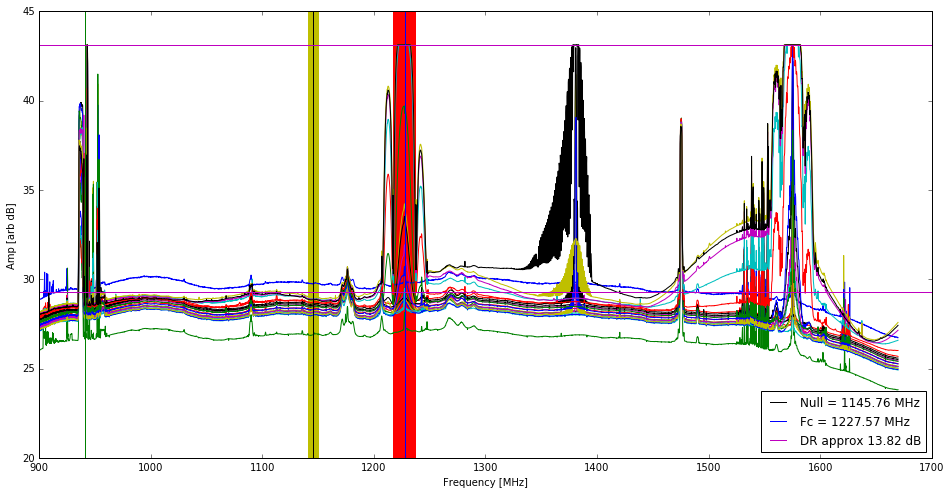

In [7]:
pylab.figure(None,figsize = (16,8))
pylab.hold(True)
cntr = nr_dumps[0]
for nidx in null_range: pylab.axvline(x=passband[nidx]/1e6, color='y')
for tidx in target_range: pylab.axvline(x=passband[tidx]/1e6, color='r')
for nr in nr_dumps[1:]:
  amplitude = numpy.mean(numpy.abs(visibilities[cntr:cntr+nr-1,:,:]), axis=0)
  pylab.plot(passband[:]/1e6, 10.*numpy.log10(amplitude[:]))
  cntr += nr
pylab.axvline(x=fnull/1e6, color='k', label='Null = %.2f MHz'%(fnull/1e6))
pylab.axvline(x=fc/1e6, color='r')
fsat=passband[numpy.argmin(numpy.abs(passband-fc))]/1e6
pylab.axvline(x=fsat, color='b', label='Fc = %.2f MHz'%fsat)
pylab.axvline(x=fcGSM/1e6, color='g')
visibilities = numpy.array(visibilities)
noisefloor = numpy.mean(10.*numpy.log10(visibilities.mean(axis=0)))
maxsignal = numpy.max(10.*numpy.log10(visibilities.max(axis=0)))
dr = (maxsignal-noisefloor)
pylab.axhline(y=maxsignal, color='m', label='DR approx %.2f dB'% numpy.abs(dr))
pylab.axhline(y=noisefloor, color='m')
pylab.hold(False)
pylab.legend(loc=0)
pylab.xlabel('Frequency [MHz]')
pylab.ylabel('Amp [arb dB]')

Using the noise models from EMSS calculations, fit linear function to use during Tsys calibration

In [8]:
def Tsys_ND(pol, passband, noisefile):
    ##Read data from file
    fin = open(noisefile, 'r')
    # Read and ignore header line
    fin.readline()
    fin.readline()
    # Read model data [freq Hz, Te K]
    nd_freqs = []
    nd_temps = []
    for line in fin.readlines():
        try:
            noisemodel= numpy.array(line.strip().split(','), dtype=float)
        except: print line.strip()
        nd_freqs.append(noisemodel[0])
        nd_temps.append(noisemodel[1])
    fin.close()
    nd_freqs = numpy.array(nd_freqs)
    nd_temps = numpy.array(nd_temps)

    coefficients  = numpy.polyfit(nd_freqs, nd_temps, 1)
    polynomial    = numpy.poly1d(coefficients)
    Tcal_passband = numpy.array(polynomial(passband))
    
    return [nd_freqs, nd_temps, Tcal_passband]

Test function for Tsys_ND: noise diode model extraction implementation

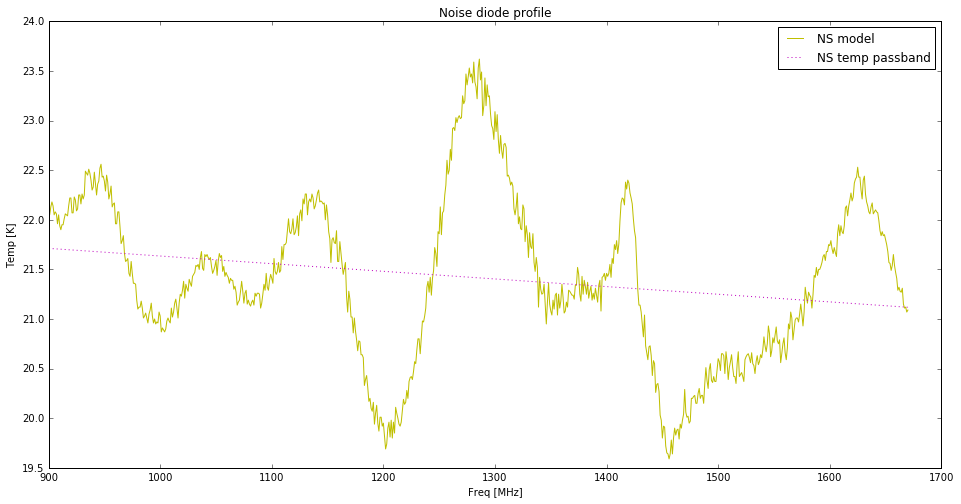

In [9]:
[nd_freqs, nd_temps, Tcal_passband] = Tsys_ND(pol, passband, noisefile)
pylab.figure(None,figsize = (16,8))
pylab.clf()
pylab.hold(True)
pylab.subplots_adjust(hspace=.7)
pylab.subplots_adjust(wspace=.7)
pylab.plot(nd_freqs/1e6, nd_temps, 'y')
pylab.plot(passband/1e6, Tcal_passband, 'm:')
pylab.hold(False)
pylab.legend(['NS model', 'NS temp passband', 'Tcal passband'], loc=0)
pylab.ylabel('Temp [K]')
pylab.xlabel('Freq [MHz]')
pylab.title('Noise diode profile')

Tsys cal for baseline region: $T_{sys} = \frac{S_{off}}{S_{on} - S_{off}} \times T_{cal}$, with $T_{cal}$ from the noide diode model data

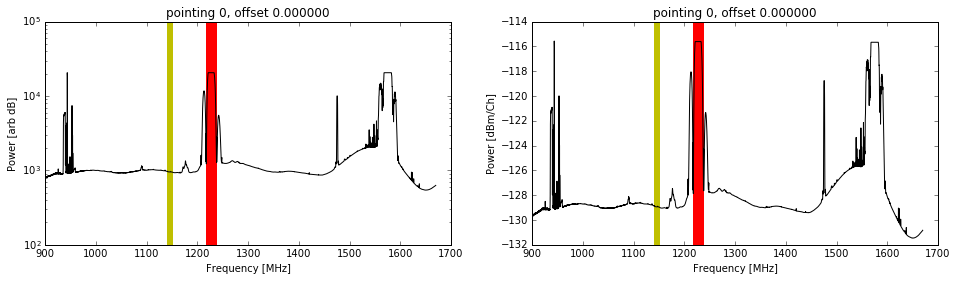

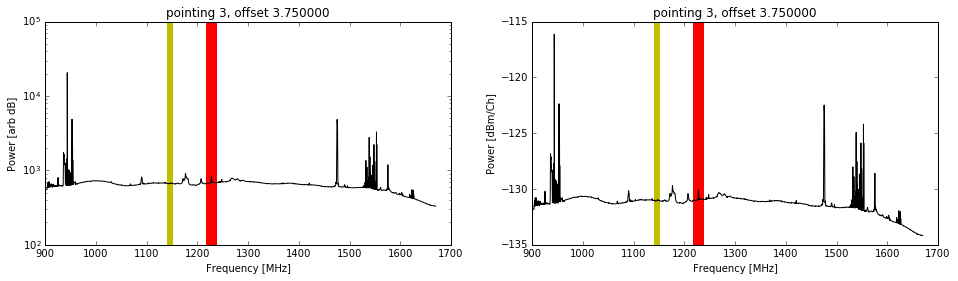

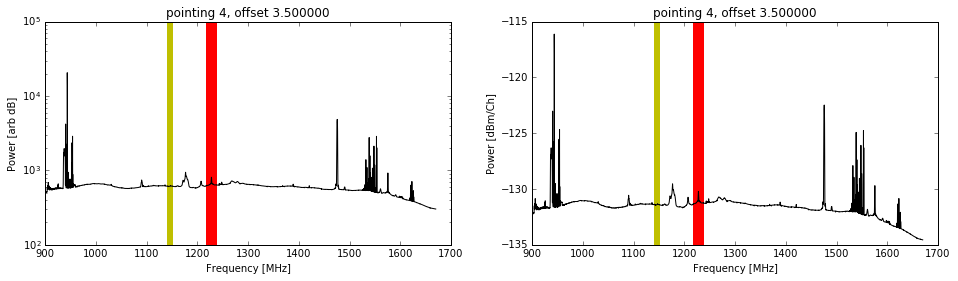

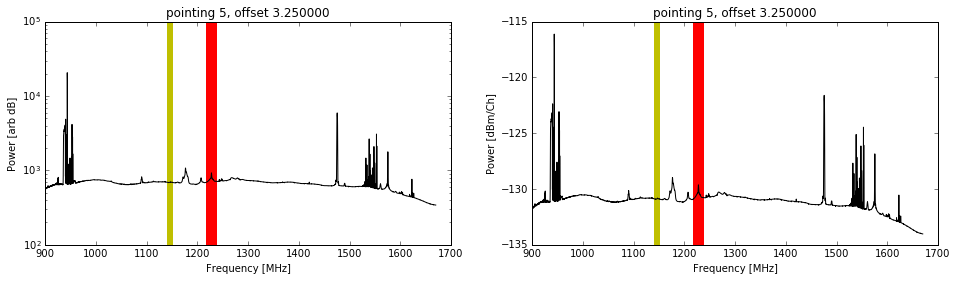

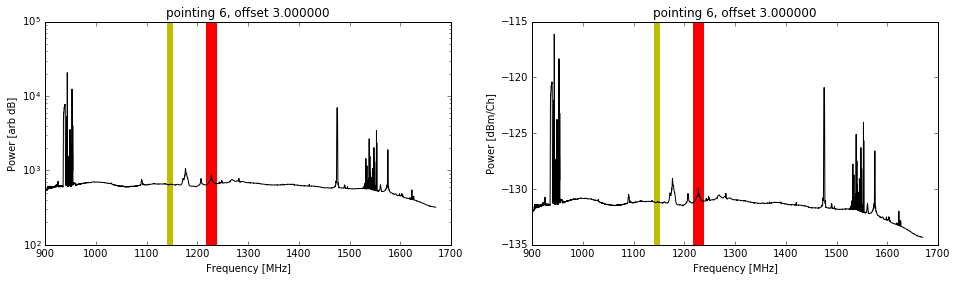

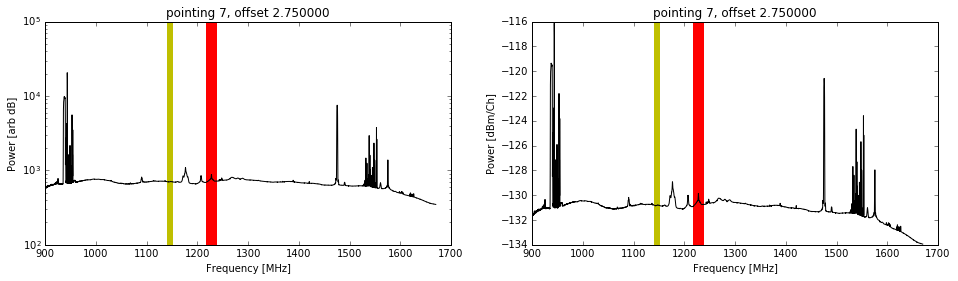

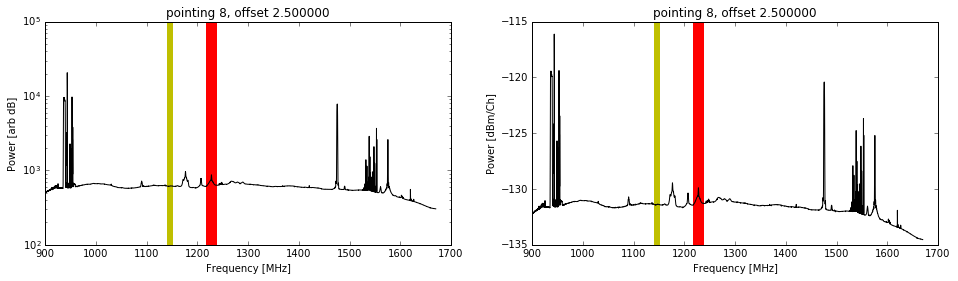

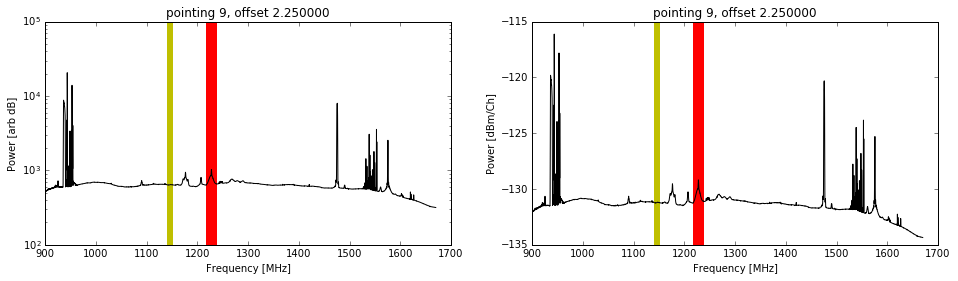

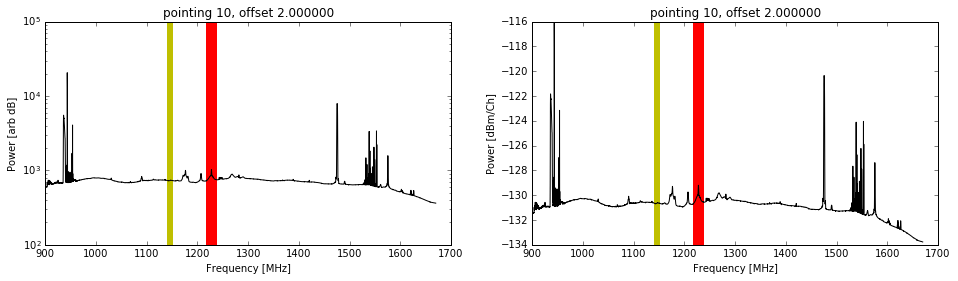

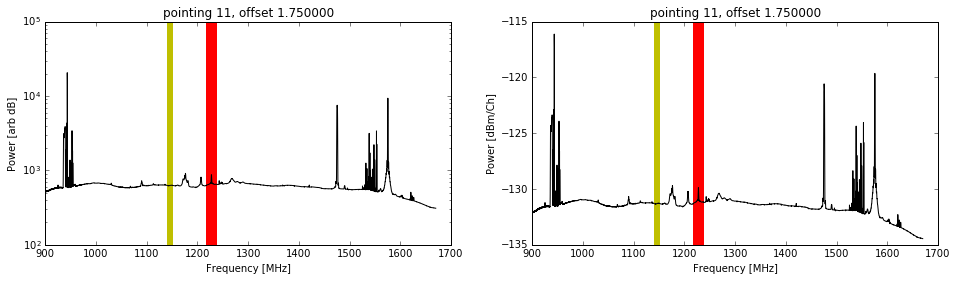

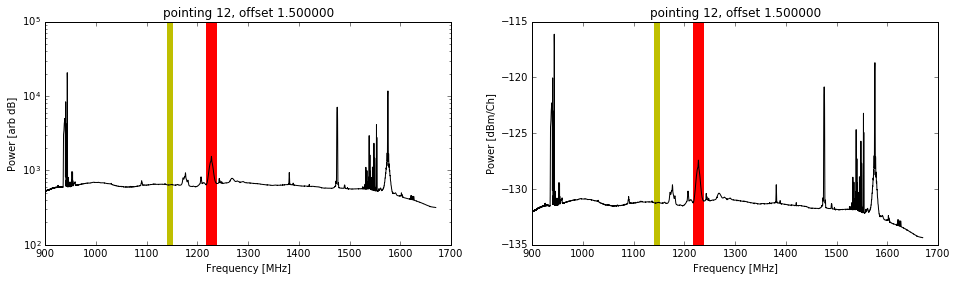

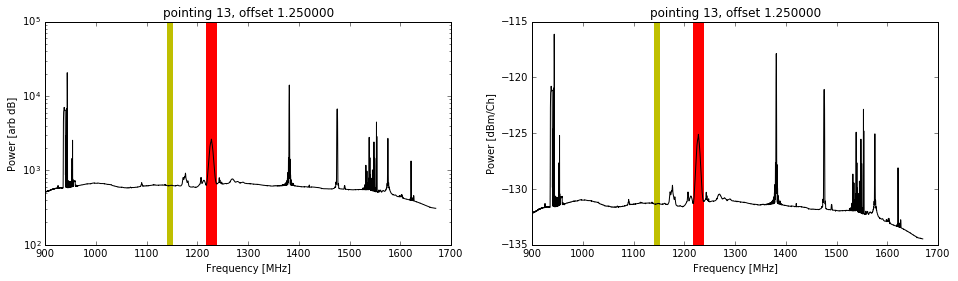

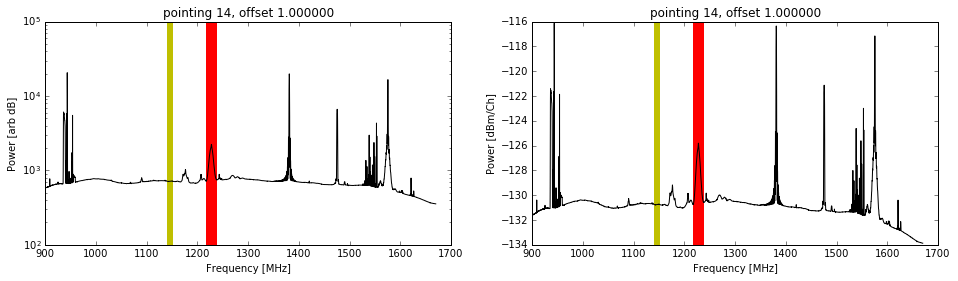

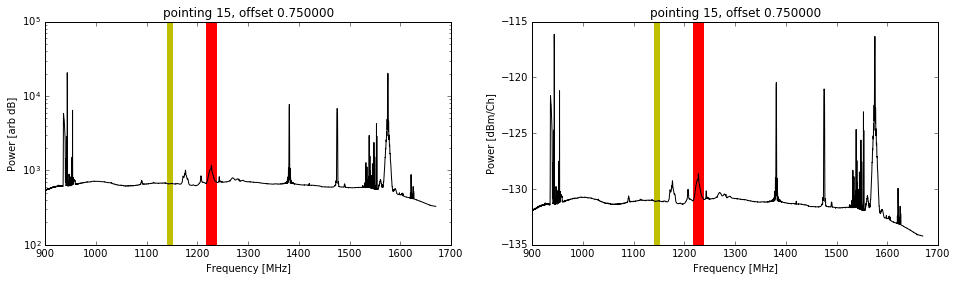

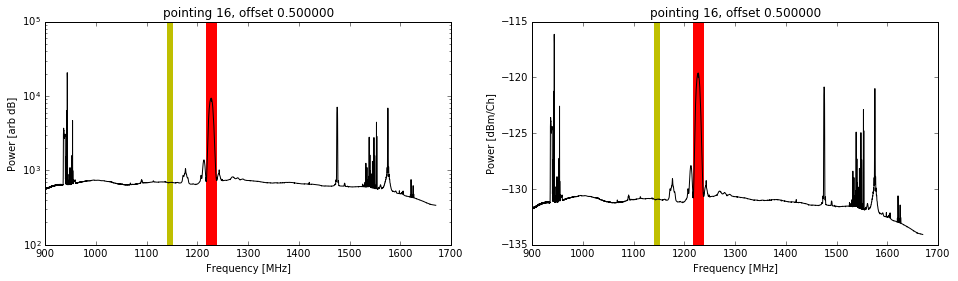

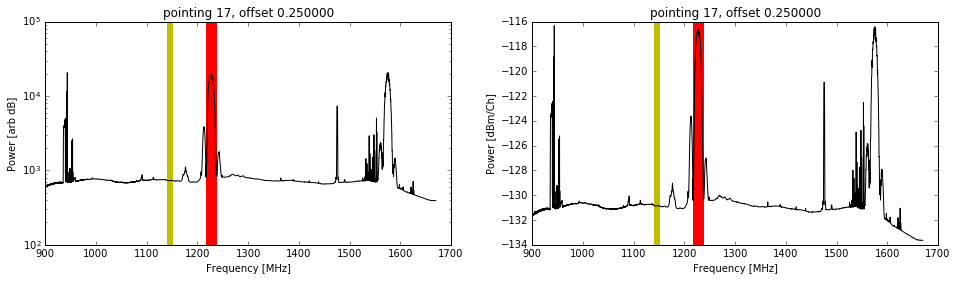

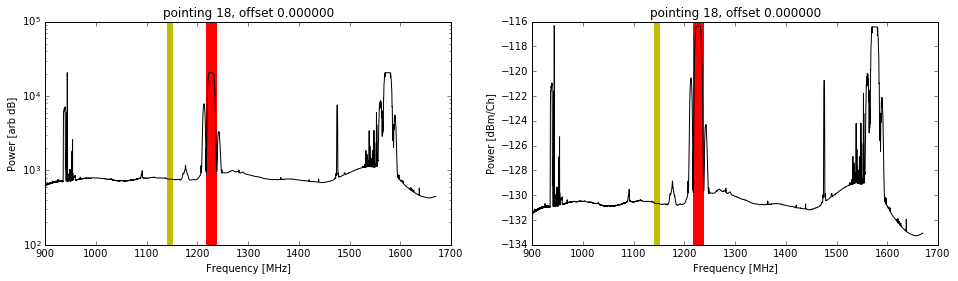

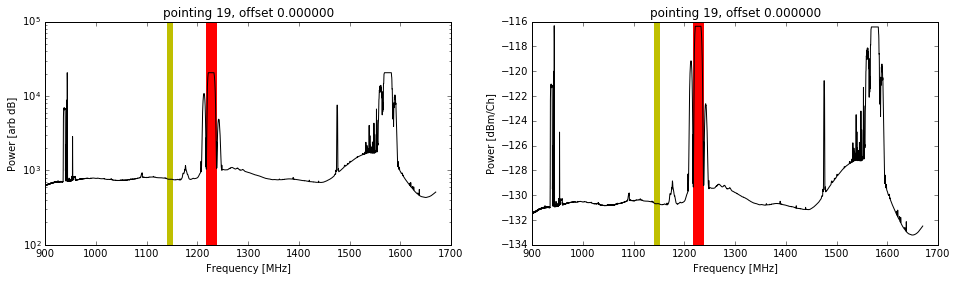

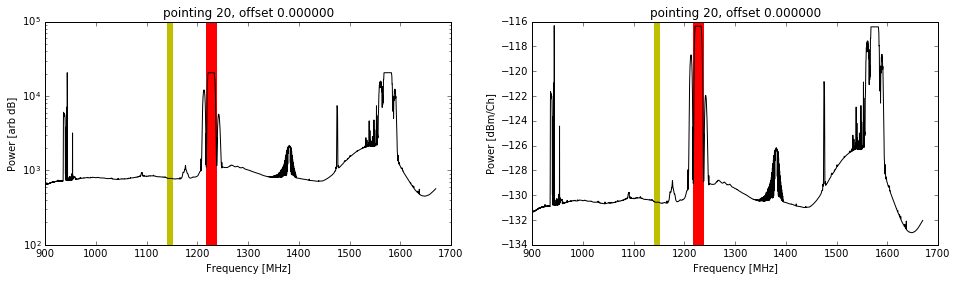

In [10]:
Pgps= []
Pns = []
Pw  = []
Pvis= []
# Per pointing calibration and analysis
cntr = 0
if len(target_offset) < len(nr_dumps): nr_dumps = nr_dumps[:len(target_offset)]
    
for point in range(0,len(nr_dumps)):
    nr = nr_dumps[point]
    vis = visibilities[cntr+1:cntr+nr,:,:]
    cntr += nr  
    
    # Calculate calibration factor for pointing from noise diode over null frequency range
    null_vis = numpy.mean(numpy.abs(vis[:,null_range]), axis=1)
    # find noise diode on and off samples
    threshold = numpy.average(null_vis)
    # everything above the threshold = with noise diode
    src_nd_idx = numpy.nonzero(null_vis > threshold)[0][1:-1]
    if len(src_nd_idx)<3:
        target_offset = numpy.delete(target_offset, point)
        continue
    S_on = numpy.mean(null_vis[src_nd_idx])
    # everything below the threshold = without noise diode
    src_idx = numpy.nonzero(null_vis < threshold)[0][1:-1]
    if len(src_idx)<3:
        target_offset = numpy.delete(target_offset, point)
        continue
    S_off = numpy.mean(null_vis[src_idx])
    # calibration scale factor
    C = numpy.array(Tcal_passband/numpy.abs(S_on-S_off))


    # Apply calibration factor to spectrum data
    mean_amp    = numpy.mean(numpy.abs(vis), axis=0).flatten()
    cal_amp_W   = k*mean_amp*B_ch*C
    cal_amp_dBm = 10.*numpy.log10(cal_amp_W) + 30
    
    
    # Compute the target and noise floor total power using numerical intergration over the frequency ranges
    Pgps.append(10.*numpy.log10(integrate.simps(cal_amp_W[target_range],passband[target_range])) + 30)
    Pns.append(10.*numpy.log10(numpy.average(cal_amp_W[null_range])) + 30)
    Pw.append(integrate.simps(cal_amp_W[target_range],passband[target_range]))
    Pvis.append(mean_amp)
    
    # Show baselines per pointing
    pylab.figure(None,figsize = (16,4))
    pylab.subplot(121)
    pylab.hold(True)
    for nidx in null_range: pylab.axvline(x=passband[nidx]/1e6, color='y')
    for tidx in target_range: pylab.axvline(x=passband[tidx]/1e6, color='r')
    pylab.semilogy(passband/1e6, mean_amp, 'k')
    pylab.hold(False)
    pylab.xlabel('Frequency [MHz]')
    pylab.ylabel('Power [arb dB]')
    if point < 1: pylab.title('pointing %d, offset %f'% (point, target_offset[-1]))
    else:
        try: pylab.title('pointing %d, offset %f'% (point, target_offset[point]))
        except: pylab.title('pointing %d, offset %f'% (point, target_offset[-1]))
    pylab.subplot(122)
    pylab.hold(True)
    for nidx in null_range: pylab.axvline(x=passband[nidx]/1e6, color='y')
    for tidx in target_range: pylab.axvline(x=passband[tidx]/1e6, color='r')
    pylab.plot(passband/1e6, cal_amp_dBm, 'k')
    pylab.hold(False)
    pylab.xlabel('Frequency [MHz]')
    pylab.ylabel('Power [dBm/Ch]')
    if point < 1: pylab.title('pointing %d, offset %f'% (point, target_offset[-1]))
    else:
        try: pylab.title('pointing %d, offset %f'% (point, target_offset[point]))
        except: pylab.title('pointing %d, offset %f'% (point, target_offset[-1]))

Evaluate receiver power over pointing angles

Digital headroom measured = 18.32 dB
System nonlinearity detected at approximately 1.25 deg off target @ GPS power -57.01 dBm


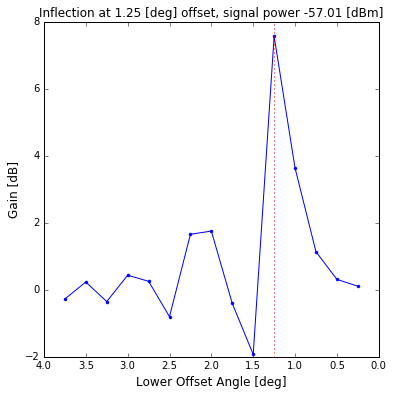

In [11]:
arb_db= 10.*numpy.log10(Pvis)
print 'Digital headroom measured = %.2f dB' % (numpy.max(arb_db)-numpy.min(arb_db))
    
# ignore suspect pointings at the beginning
Pgps=Pgps[3:] 
Pns =Pns[3:]
Pw  =Pw[3:]
target_offset=target_offset[3:]

# find inflection point using GPS power calculated
inf_idx = numpy.argmax(numpy.abs(numpy.diff(Pgps)))
gps_offset_nonlinear = target_offset[inf_idx]
# Compare with noise diode value
offset_nonlinear = numpy.min((noise_offset_nonlinear,gps_offset_nonlinear))
offset_idx = numpy.argmin(numpy.abs(offset_nonlinear-target_offset))
print 'System nonlinearity detected at approximately %.2f deg off target @ GPS power %.2f dBm' % (gps_offset_nonlinear, Pgps[inf_idx])

pylab.figure(None,figsize = (6,6))
# for GPS and other CW RFI sources this inflexion point will be obvious
pylab.plot(target_offset[:len(Pgps)][:-1],numpy.diff(Pgps), 'b.-')
pylab.axvline(x=target_offset[:len(Pgps)][inf_idx], color='r', linestyle=':')
pylab.gca().invert_xaxis()
pylab.title('Inflection at %.2f [deg] offset, signal power %.2f [dBm]' %
           (gps_offset_nonlinear, Pgps[inf_idx]), fontsize=12)
pylab.ylabel('Gain [dB]', fontsize=12)
pylab.xlabel('Lower Offset Angle [deg]', fontsize=12)

Input power from EIRP calculations

In [12]:
EIRP = 60 # dBW
l = (3e8/fc) # wavelength in m
n=0.8
D= h5.ants[0].diameter # m
d_aph =38899e3 # m
d_wiki=20200e3 # m

gain = 10.*numpy.log10(n*(numpy.pi*D/l)**2) # dB
print 'Estimated forward gain of RTS antenna %.2f [dBi]' % gain

path_loss = 20.*numpy.log10(4*numpy.pi*d_aph/l) # dB
Paph = EIRP +30 - path_loss + gain
print "Expected GPS receiver power %f [dBm] for distance %d [km]" % (Paph, int(d_aph/1e3))
path_loss = 20.*numpy.log10(4*numpy.pi*d_wiki/l) # dB
Pwiki = EIRP +30 - path_loss + gain
print "Expected GPS receiver power %f [dBm] for distance %d [km]" % (Pwiki, int(d_wiki/1e3))

Estimated forward gain of RTS antenna 43.82 [dBi]
Expected GPS receiver power -52.202393 [dBm] for distance 38899 [km]
Expected GPS receiver power -46.510652 [dBm] for distance 20200 [km]


Give test results

In [13]:
spec = -57 # dBm
print"Description: %s\nName: %s\nExperiment ID: %s\n\n" %(h5.description, h5.name, h5.experiment_id)
print "Antenna: %s\nPolarisation: %s\n" %(ant, pol)
print
print "Linearity requirement: (P1dB input >= -57dBm)"
print
print "Measurement results\n"


print 'System nonlinearity detected at approximately %.2f deg off target @ GPS power %.2f dBm' % (gps_offset_nonlinear, Pgps[inf_idx])

results  = 'Compression inflection at %.2f [deg] offset with GPS signal power %.2f[dBm]\n' % \
           (gps_offset_nonlinear, Pgps[inf_idx])
results += 'Average power %.2f [dBm] at %.2f [MHz] null\n' % (numpy.mean(Pns[:inf_idx]), fnull/1e6)
results = results + "\n"

results += "Input power spec\n"
if (Pgps[inf_idx]-spec) < 0: results += '[Fail] Receiver power at receiver %.2f dB < %.2f dBm' % (abs(Pgps[inf_idx]-spec), spec)
else: results +='[Success] Receiver power at compression angle %.2f dB >= %.2f dBm' % (abs(Pgps[inf_idx]-spec), spec)
results = results + "\n"

results += "Dynamic range\n"
if (dr - 27) < 0: results += '[Fail] Not enough dynamic range %.2f dB < 27 dB' % numpy.abs(dr)
else: results += '[Success] Enough dynamic range %.2f dB >= 27 dB' % numpy.abs(dr)
print results + "\n"


Description: Linearity scan onto GPS
Name: /var/kat/archive/data/MeerKATAR1/telescope_products/2016/03/17/1458202426.h5
Experiment ID: 20160317-0031


Antenna: m034
Polarisation: V


Linearity requirement: (P1dB input >= -57dBm)

Measurement results

System nonlinearity detected at approximately 1.25 deg off target @ GPS power -57.01 dBm
Compression inflection at 1.25 [deg] offset with GPS signal power -57.01[dBm]
Average power -131.08 [dBm] at 1145.76 [MHz] null

Input power spec
[Fail] Receiver power at receiver 0.01 dB < -57.00 dBm
Dynamic range
[Fail] Not enough dynamic range 13.82 dB < 27 dB

